<a href="https://colab.research.google.com/github/seven320/air_pollutants/blob/main/FP009_008_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Env

In [1]:
!nvidia-smi

Tue Apr 19 12:03:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os, sys
COLAB = "google.colab" in sys.modules

if COLAB:
    from google.colab import drive
    from google.colab import output
    drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
if COLAB:
    !pip install transformers > /dev/null
    !pip install einops > /dev/null
    !pip install optuna > /dev/null
    # !pip install timm > /dev/null
    # !pip install kaggle > /dev/null
    # !pip install kaggle_datasets > /dev/null
    # !pip install git+https://github.com/albumentations-team/albumentations
    # !pip install tensorflow-determinism
    !pip install -q iterative-stratification
    !pip install python-Levenshtein > /dev/null

    # for gpu
    !git clone --recursive https://github.com/Microsoft/LightGBM
    %cd /content/LightGBM/
    !mkdir build
    !cmake -DUSE_GPU=1 
    !make -j$(nproc)
    !sudo apt-get -y install python-pip

    !sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
    #pandasのエラーが出る場合は上記のコードからpandasを削除

    !sudo -H pip install setuptools numpy scipy scikit-learn -U
    %cd /content/LightGBM/python-package
    !sudo python setup.py install --precompile

    output.clear()

In [4]:
import gc
import json
import math
import os
import random
import re
import time
import copy
import warnings
from requests import get
from contextlib import contextmanager
from typing import List, Optional, TypeVar, Type, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, train_test_split, KFold
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
# from einops.layers.torch import Rearrange, Reduce
# import timm
import Levenshtein

from tqdm.notebook import tqdm
from transformers import AdamW, get_cosine_schedule_with_warmup
from typing import Optional, Tuple
from xgboost import XGBRegressor
import lightgbm as lgb
import optuna

In [5]:
warnings.simplefilter('ignore')

In [6]:
if COLAB:    
    NOTEBOOK_NAME = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
    print(NOTEBOOK_NAME)

FP009-008-tuning


In [7]:
COMPE_NAME = "air_pollutants"
BASE_DIR = f"/content/drive/MyDrive/signate/{COMPE_NAME}"

# KAGGLE ONLY HAS 1, BUT OFFLINE, YOU CAN USE MORE
os.environ["CUDA_VISIBLE_DEVICES"]="0" #0,1,2,3 for four gpu

In [8]:
if COLAB:
    INPUT_DIR = Path(os.path.join(BASE_DIR ,f"input"))
    INPUT_DIR.mkdir(exist_ok=True, parents=True)

    SAVE_DIR = Path(os.path.join(BASE_DIR ,f"models/{NOTEBOOK_NAME}"))
    SAVE_DIR.mkdir(exist_ok=True, parents=True)

    OOF_DIR = Path(os.path.join(BASE_DIR, f"oof/{NOTEBOOK_NAME}"))
    OOF_DIR.mkdir(exist_ok=True, parents = True)

    SUB_DIR = Path(os.path.join(BASE_DIR, f"submission/{NOTEBOOK_NAME}"))
    SUB_DIR.mkdir(exist_ok=True, parents = True)

In [9]:
train_df = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
sample_df = pd.read_csv(os.path.join(INPUT_DIR, "submit_sample.csv"), names=["id", "predict"])

print(train_df.shape, test_df.shape, sample_df.shape)

(195941, 54) (53509, 53) (53509, 2)


# add city population

In [10]:
population_df = pd.read_csv(os.path.join(INPUT_DIR, "city_population.csv"))
population_df["City"] = population_df["Name"]

In [11]:
# 同じ都市名かつ国名のものを削除する
population_df["CC"] = population_df["Country"] + population_df["City"]
population_df["CC"].value_counts()
for k, v in population_df["CC"].value_counts().items():
    # print(k, v)
    if v > 1:
        print(f"{k} の行を削除")
        population_df = population_df[population_df["CC"] != k]

ChinaSuzhou の行を削除


In [12]:
def df_to_country_dict(df: pd.DataFrame) -> Dict:
    country_city = {}

    for t_c in set(df["Country"].tolist()):
        country_city[t_c] = []

    for country, city in zip(df["Country"], df["City"]):
        country_city[country].append(city)

    for k, v in country_city.items():
        country_city[k] = set(v)

    return country_city
    

In [13]:
train_country_city = df_to_country_dict(pd.concat([train_df, test_df]))

p_country_city = df_to_country_dict(population_df)

In [14]:
def cal_leven(str1: str, str2: str) -> float:
    # レーベンシュタイン距離の取得
    lev_dist = Levenshtein.distance(str1, str2)
    # 標準化(長い方の文字列の長さで割る)
    divider = len(str1) if len(str1) > len(str2) else len(str2)
    lev_dist = lev_dist / divider
    # 指標を合わせる(0:完全不一致 → 1:完全一致)
    return 1 - lev_dist

In [15]:
city_pairs = {}

for t_k, t_values in train_country_city.items():
    for p_k, p_values in p_country_city.items():
        # countryが一致
        if t_k != p_k:
            continue
        for t_v in t_values:
            max_score = -1
            for p_v in p_values:
                score = cal_leven(t_v, p_v)
                if max_score < score:
                    pairs = [t_v, p_v]
                    max_score = score

            if max_score > 0.8:
                city_pairs[pairs[1]] = pairs[0]
print(f"pair cities:{len(city_pairs)}")

pair cities:177


In [16]:
a = population_df["City"]
for key, value in city_pairs.items():
    # print(key, value)
    a = copy.deepcopy(a.replace(key, value))

population_df["City"] = a

In [17]:
train_df

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,...,ws_min,ws_mid,ws_max,ws_var,dew_cnt,dew_min,dew_mid,dew_max,dew_var,pm25_mid
0,1,2019,1,1,Australia,Brisbane,-27.46794,153.02809,38,0.749,...,0.241,1.088,3.101,1.983,17,7.671,10.358,15.112,13.424,19.901
1,2,2019,1,1,Australia,Darwin,-12.46113,130.84185,47,2.594,...,0.828,3.473,7.396,10.411,62,21.324,23.813,24.221,2.021,13.741
2,3,2019,1,1,Australia,Melbourne,-37.81400,144.96332,17,1.190,...,0.000,2.107,8.089,15.719,22,10.309,13.133,15.422,6.355,25.918
3,4,2019,1,1,Australia,Newcastle,-32.92953,151.78010,63,4.586,...,0.284,0.503,3.592,2.485,116,7.146,10.685,13.344,9.417,174.370
4,5,2019,1,1,Australia,Perth,-31.95224,115.86140,47,4.689,...,0.500,0.755,3.396,1.937,93,1.091,3.277,12.272,4.109,167.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195936,195937,2021,12,31,United States,Jacksonville,30.33218,-81.65565,12,0.694,...,2.195,2.710,6.125,3.757,12,16.774,22.679,26.058,13.252,16.150
195937,195938,2021,12,31,United States,Las Vegas,36.17497,-115.13722,14,0.528,...,1.002,2.974,6.861,8.354,12,10.432,14.741,15.827,7.078,16.895
195938,195939,2021,12,31,United States,Milwaukee,43.03890,-87.90647,171,1.975,...,0.994,1.087,2.578,0.612,26,2.049,3.531,6.686,5.286,86.299
195939,195940,2021,12,31,Vietnam,Hanoi,21.02450,105.84117,31,2.613,...,1.005,3.058,6.005,6.085,51,1.922,7.443,7.716,4.642,36.523


In [18]:
if not "Prev" in train_df.columns:
    train_df = train_df.merge(population_df[["rank", "City", "Country", "Population", "Prev", "Growth"]], on = ["City", "Country"], how="left")
    test_df = test_df.merge(population_df[["rank", "City", "Country",  "Population", "Prev", "Growth"]], on = ["City", "Country"], how="left")

assert len(test_df) == len(sample_df)

In [19]:
# Config
NUM_FOLDS = 5

In [20]:
#############
## Utility ##
#############
@contextmanager
def timer(name: str):
    t0 = time.time()
    print(f"[{name}] start")
    yield
    print(f"[{name}] done - elapsed {time.time() - t0:.2f}s")

In [21]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [22]:
train_df.head()

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,...,dew_cnt,dew_min,dew_mid,dew_max,dew_var,pm25_mid,rank,Population,Prev,Growth
0,1,2019,1,1,Australia,Brisbane,-27.46794,153.02809,38,0.749,...,17,7.671,10.358,15.112,13.424,19.901,201.0,2472222.0,2439467.0,0.0134
1,2,2019,1,1,Australia,Darwin,-12.46113,130.84185,47,2.594,...,62,21.324,23.813,24.221,2.021,13.741,NaN,NaN,NaN,NaN
2,3,2019,1,1,Australia,Melbourne,-37.81400,144.96332,17,1.190,...,22,10.309,13.133,15.422,6.355,25.918,79.0,5150766.0,5061439.0,0.0176
3,4,2019,1,1,Australia,Newcastle,-32.92953,151.78010,63,4.586,...,116,7.146,10.685,13.344,9.417,174.370,NaN,NaN,NaN,NaN
4,5,2019,1,1,Australia,Perth,-31.95224,115.86140,47,4.689,...,93,1.091,3.277,12.272,4.109,167.063,242.0,2092649.0,2067333.0,0.0122


In [23]:
train_city = train_df["City"].unique().tolist()
test_city = test_df["City"].unique().tolist()

train_city_cnt = len(train_city)
test_city_cnt = len(test_city)

print(f"train city count: {train_city_cnt}")
print(f"test city count: {test_city_cnt}")

print(f"{len(set(train_city) & set(test_city))}")

train city count: 239
test city count: 63
0


In [24]:
kf = GroupKFold(n_splits = NUM_FOLDS)

if not "kfold" in train_df.columns:
    folds = copy.deepcopy(train_df[["id"]])
    folds["kfold"] = -1

    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df, train_df["pm25_mid"], train_df["City"])):
        print(f"train_idx: {len(train_idx)}, valid_idx: {len(valid_idx)}")
        folds.loc[valid_idx, "kfold"] = fold

    train_df = train_df.merge(folds[["id", "kfold"]], on="id", how="left")

train_idx: 156755, valid_idx: 39186
train_idx: 156758, valid_idx: 39183
train_idx: 156760, valid_idx: 39181
train_idx: 156730, valid_idx: 39211
train_idx: 156761, valid_idx: 39180


# Train

In [25]:
import logging
from typing import List, Optional, TypeVar

import pandas as pd

class AbstractFeatureTransformer:
    def __init__(self):
        self.name = self.__class__.__name__

    def fit_transform(self, input_df: pd.DataFrame, y=None):
        self.fit(input_df, y)
        return self.transform(input_df)

    def fit(self, input_df: pd.DataFrame, y=None):
        pass

    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError

Transformer = TypeVar("Transformer", bound=AbstractFeatureTransformer)

def extract_features(input_df: pd.DataFrame,
                     transformers: List[Transformer],
                     fit: bool = True,
                     logger: Optional[logging.Logger] = None):
    feature_dfs = []
    for transformer in transformers:
        # timerはブロックの実行時間を計測するユーティリティ
        with timer(f"Extract features with {transformer.name}", logger):
            if fit:
                feature_dfs.append(transformer.fit_transform(input_df))
            else:
                feature_dfs.append(transformer.transform(input_df))
    all_features = pd.concat(feature_dfs, axis=1)
    return all_features

In [26]:
class Numericals(AbstractFeatureTransformer):
    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        cols = [pd.api.types.is_numeric_dtype(dtype) for dtype in input_df.dtypes]
        return input_df.loc[:, cols]

class LabelEncoding(AbstractFeatureTransformer):
    def __init__(self, columns: List[str]):
        super().__init__()
        self.le_columns = columns
        self.encoders = {
            column: LabelEncoder()
            for column in self.le_columns
        }
        self.__is_fitted = False

    def fit(self, input_df: pd.DataFrame, y: Optional[np.ndarray] = None):
        """
        ラベルに変換する前に欠損値を埋める
        """
        for column in self.le_columns:
            self.encoders[column].fit(input_df[column].fillna(""))
        self.__is_fitted = True

    def transform(
        self, 
        input_df: pd.DataFrame, 
        y: Optional[np.ndarray] = None
    ) -> pd.DataFrame:
        assert self.__is_fitted, "You need to call `fit` first."
        encoded = {}
        for column in self.le_columns:
            encoded[column] = self.encoders[column].transform(
                input_df[column].fillna(""))
        return pd.DataFrame(encoded)

In [27]:
def preprocess(df:pd.DataFrame)->pd.DataFrame:
    df_ = copy.deepcopy(df)
    # 経度をcosに変換
    cnt = 0

    df_["lon_cos"] = np.cos(np.radians((df_["lon"] + 180)))
    df_["lon_sin"] = np.sin(np.radians((df_["lon"] + 180)))
    df_["month_cos"] = np.cos(np.radians(df_["month"] / 12 * 360))
    df_["month_sin"] = np.sin(np.radians(df_["month"] / 12 * 360))
    cnt += 4

    # 四則演算

    # 南半球を北半球のmonthに変更
    df_["month_world"] = df_["month"]
    df_.loc[df_["lat"] < 0, "month_world"] = df_["month"] + 6
    df_.loc[df_["month_world"] > 12, "month_world"] = df_["month"] - 6

    cnt += 1
    # mid同士を4則
    columns = df_.columns
    mids = []
    for c in columns:
        if "_mid" in c and c != "pm25_mid":
            mids.append(c)
    scaler = MinMaxScaler()
    
    # scaling_columns = []
    # for i in range(len(mids)):
    #     for j in range(i):
    #         df_[f"{mids[i]}x{mids[j]}"] = df_[mids[i]] * df_[mids[j]]
    #         df_[f"{mids[i]}/{mids[j]}"] = df_[mids[i]] / (df_[mids[j]] + 1e-6)
    #         df_[f"{mids[i]}+{mids[j]}"] = df_[mids[i]] + df_[mids[j]]
    #         df_[f"{mids[i]}-{mids[j]}"] = df_[mids[i]] - df_[mids[j]]
    #         cnt += 4

    #         scaling_columns += [f"{mids[i]}x{mids[j]}", f"{mids[i]}/{mids[j]}", f"{mids[i]}+{mids[j]}", f"{mids[i]}-{mids[j]}"]
    print(f"add {cnt} columns")

    # df_[scaling_columns] = scaler.fit_transform(df_[scaling_columns])

    print("scaled columns")

    return df_

In [28]:
# label encoding

cat_cols = ["Country", "City"]

for c in cat_cols:
    le = LabelEncoder()
    le.fit(pd.concat([train_df, test_df])[c])
    train_df[c] = le.transform(train_df[c])
    test_df[c] = le.transform(test_df[c])

In [29]:
train_df_ = preprocess(train_df)
test_df_ = preprocess(test_df)

add 5 columns
scaled columns
add 5 columns
scaled columns


In [30]:
train_df_.head(20)

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,...,rank,Population,Prev,Growth,kfold,lon_cos,lon_sin,month_cos,month_sin,month_world
0,1,2019,1,1,0,24,-27.46794,153.02809,38,0.749,...,201.0,2472222.0,2439467.0,0.0134,0,0.891229,-0.453554,0.866025,0.5,7
1,2,2019,1,1,0,54,-12.46113,130.84185,47,2.594,...,NaN,NaN,NaN,NaN,2,0.653973,-0.756518,0.866025,0.5,7
2,3,2019,1,1,0,146,-37.81400,144.96332,17,1.190,...,79.0,5150766.0,5061439.0,0.0176,2,0.818785,-0.574101,0.866025,0.5,7
3,4,2019,1,1,0,176,-32.92953,151.78010,63,4.586,...,NaN,NaN,NaN,NaN,1,0.881139,-0.472857,0.866025,0.5,7
4,5,2019,1,1,0,193,-31.95224,115.86140,47,4.689,...,242.0,2092649.0,2067333.0,0.0122,1,0.436196,-0.899852,0.866025,0.5,7
5,6,2019,1,1,0,278,-34.42400,150.89345,179,4.554,...,NaN,NaN,NaN,NaN,0,0.873717,-0.486435,0.866025,0.5,7
6,7,2019,1,1,1,8,51.22047,4.40026,93,4.011,...,NaN,NaN,NaN,NaN,3,-0.997052,-0.076724,0.866025,0.5,1
7,8,2019,1,1,1,38,50.41136,4.44448,11,0.096,...,NaN,NaN,NaN,NaN,3,-0.996993,-0.077493,0.866025,0.5,1
8,9,2019,1,1,1,137,50.63373,5.56749,12,0.097,...,NaN,NaN,NaN,NaN,0,-0.995283,-0.097018,0.866025,0.5,1
9,10,2019,1,1,3,247,-23.54750,-46.63611,354,1.048,...,5.0,22429800.0,22237472.0,0.0086,0,-0.686629,0.727008,0.866025,0.5,7


In [31]:
# numericals = Numericals()
# 数字に関する変換
# train_df_num = numericals.transform(train_df)

# ラベルに関する変換
# labelencoding = LabelEncoding(columns = [])

# labelencoding.fit(train_df_num)
# train_df_labeled = labelencoding.transform(train_df_num)

In [32]:
class AbstractTreeModel:
    def __init__(self, prediction_type="regression"):
        self.model = None
        self.prediction_type = prediction_type

    def train(self,
              params: dict,
              X_train: pd.DataFrame,
              y_train: np.ndarray,
              X_val: pd.DataFrame,
              y_val: np.ndarray,
              train_weights: Optional[np.ndarray] = None,
              val_weights: Optional[np.ndarray] = None,
              train_params: Optional[dict] = None):
        if train_params is None:
            train_params = {}

        model = self._train(
            params,
            X_train, y_train,
            X_val, y_val,
            train_weights, val_weights,
            train_params)
        self.model = model
        return self

    def _train(self,
               params,
               X_train,
               y_train,
               X_val,
               y_val,
               train_weights,
               val_weights,
               train_params):
        raise NotImplementedError

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        raise NotImplementedError

    @property
    def feature_names_(self):
        raise NotImplementedError

    @property
    def feature_importances_(self):
        raise NotImplementedError

    def _check_if_trained(self):
        assert self.model is not None, "You need to train the model first"


class LGBModel(AbstractTreeModel):
    def _train(self,
               params,
               X_train, y_train,
               X_val, y_val,
               train_weights, val_weights,
               train_params):
        trn_data = lgb.Dataset(X_train, y_train, weight=train_weights)
        val_data = lgb.Dataset(X_val, y_val, weight=val_weights)
        model = lgb.train(params=params,
                          train_set=trn_data,
                          valid_sets=[trn_data, val_data],
                          **train_params,)
                        #   verbose_eval=False)
        return model

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        self._check_if_trained()
        return self.model.predict(X, num_iteration=self.model.best_iteration)

    @property
    def feature_names_(self):
        self._check_if_trained()
        return self.model.feature_name()

    @property
    def feature_importances_(self):
        self._check_if_trained()
        return self.model.feature_importance(importance_type="gain")


def get_tree_model(name: str) -> Type[AbstractTreeModel]:
    DEFINED_MODELS = {
        "lgb": LGBModel,
        # 実装していない
        # "xgb": XGBModel,
        # "cat": CatBoostModel
    }
    model = DEFINED_MODELS.get(name)
    if model is None:
        raise ValueError(
            """Invalid model name: {}.
            Pre-defined model names are as follows: {}""".format(
                name,
                ",".join(DEFINED_MODELS.keys())
            ))
    return model

In [33]:
def viz_feature_importances(feature_importances: pd.DataFrame)-> None:
    fi_gby = feature_importances.groupby("feature").agg({
        "importance": ["mean", "std"]
    }).sort_values(("importance", "mean"), ascending=0).index
    plt.figure(figsize=(20, 10))

    sns.barplot(x="importance", y="feature", data=feature_importances, order=fi_gby)

    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    # plt.savefig('lgbm_importances-01.png')

In [84]:
train_params = {
    "num_boost_round": 10000,
    "callbacks": [
                  lgb.early_stopping(stopping_rounds= 200, verbose=True),
                  lgb.log_evaluation(period = 500)
    ]
}

In [49]:
model = get_tree_model("lgb")()

num_cols = [c for c in train_df_.columns if train_df_[c].dtype != np.object]
if "id" in num_cols:
    num_cols.remove("id")
if "kfold" in num_cols:
    num_cols.remove("kfold")
num_cols.remove("pm25_mid")

target_cols = "pm25_mid"

In [50]:
use_cols = [
'year',
'month', 
# 'day', 
'lat', 'lon',
 'co_cnt', 'co_min', 'co_mid', 'co_max', 'co_var', 
 'o3_cnt', 'o3_min', 'o3_mid', 'o3_max', 'o3_var', 
 'so2_cnt', 'so2_min', 'so2_mid', 'so2_max', 'so2_var', 'no2_cnt', 
 'no2_min', 'no2_mid', 'no2_max', 'no2_var',
'temperature_cnt', 'temperature_min', 'temperature_mid', 'temperature_max', 'temperature_var', 
'humidity_cnt', 'humidity_min', 'humidity_mid', 'humidity_max', 'humidity_var', 
'pressure_cnt', 'pressure_min', 'pressure_mid', 'pressure_max', 'pressure_var', 
'ws_cnt', 'ws_min', 'ws_mid', 'ws_max', 'ws_var', 
'dew_cnt', 'dew_min', 'dew_mid', 'dew_max', 'dew_var', 
'rank', 'Population', 'Prev', 'Growth', 'lon_cos', 'lon_sin', 'month_cos', 'month_sin', 'month_world'
] + cat_cols

In [89]:
i = 1
train_data = train_df_[train_df_["kfold"] != i].reset_index(drop = True)
valid_data = train_df_[train_df_["kfold"] == i].reset_index(drop = True)

lgb_train = lgb.Dataset(train_data[use_cols], train_data[target_cols])
lgb_eval = lgb.Dataset(valid_data[use_cols], valid_data[target_cols])


def objective(trial):
    params= {
            'boosting': 'gbdt',
            'objective': 'rmse',
            'metric': 'rmse',
            'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.1),
            "max_depth": trial.suggest_categorical("max_depth", [8, 16, 32]),
            "num_leaves": trial.suggest_categorical("num_leaves", [8, 16, 32, 64]),
            'subsample': 0.7,
            'subsample_freq': 1,
            "min_data_in_leaf":30, 
            "device": "gpu",  
            "seed":2022,
    }

    gbm = lgb.train(params, lgb_train, valid_sets=lgb_eval, **train_params)
    preds = gbm.predict(valid_data[use_cols])

    accuracy = np.sqrt(mean_squared_error(valid_data[target_cols], preds))
    return accuracy

In [91]:
study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 50)

[I 2022-04-19 12:54:55,796] A new study created in memory with name: no-name-e28b8a48-bed7-4b4f-9b89-63604cb11219


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.012300 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.3979
[1000]	valid_0's rmse: 21.2946
Early stopping, best iteration is:
[1239]	valid_0's rmse: 21.2692


[I 2022-04-19 12:55:07,776] Trial 0 finished with value: 21.26924628191411 and parameters: {'learning_rate': 0.06251589821700465, 'max_depth': 32, 'num_leaves': 16}. Best is trial 0 with value: 21.26924628191411.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.008150 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 24.9367
[1000]	valid_0's rmse: 22.8769
[1500]	valid_0's rmse: 22.1897
[2000]	valid_0's rmse: 21.8681
[2500]	valid_0's rmse: 21.6584
[3000]	valid_0's rmse: 21.5106
[3500]	valid_0's rmse: 21.4124
[4000]	valid_0's rmse: 21.338
[4500]	valid_0's rmse: 21.2813
[5000]	valid_0's rmse: 21.2435
[5500]	valid_0's rmse: 21.2138
[6000]	valid_0's rmse: 21.1925


[I 2022-04-19 12:58:35,993] Trial 1 finished with value: 21.09865653847205 and parameters: {'learning_rate': 0.00202375133369951, 'max_depth': 16, 'num_leaves': 64}. Best is trial 1 with value: 21.09865653847205.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007792 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.3074
Early stopping, best iteration is:
[619]	valid_0's rmse: 21.3


[I 2022-04-19 12:58:44,930] Trial 2 finished with value: 21.299978558013866 and parameters: {'learning_rate': 0.08316989406730703, 'max_depth': 32, 'num_leaves': 32}. Best is trial 1 with value: 21.09865653847205.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.008029 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[281]	valid_0's rmse: 21.4594


[I 2022-04-19 12:58:50,334] Trial 3 finished with value: 21.459438478621802 and parameters: {'learning_rate': 0.09752154455827944, 'max_depth': 16, 'num_leaves': 32}. Best is trial 1 with value: 21.09865653847205.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.012666 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.6283
[1000]	valid_0's rmse: 21.3309
[1500]	valid_0's rmse: 21.2629
[2000]	valid_0's rmse: 21.2088
[2500]	valid_0's rmse: 21.2
[3000]	valid_0's rmse: 21.1746
Early stopping, best iteration is:
[3209]	valid_0's rmse: 21.1646


[I 2022-04-19 12:59:29,965] Trial 4 finished with value: 21.164561500196488 and parameters: {'learning_rate': 0.01782760406034501, 'max_depth': 16, 'num_leaves': 32}. Best is trial 1 with value: 21.09865653847205.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007936 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[215]	valid_0's rmse: 21.2986


[I 2022-04-19 12:59:37,314] Trial 5 finished with value: 21.29855066969297 and parameters: {'learning_rate': 0.08578852796881131, 'max_depth': 32, 'num_leaves': 64}. Best is trial 1 with value: 21.09865653847205.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007821 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.9129
[1000]	valid_0's rmse: 21.5226
[1500]	valid_0's rmse: 21.3864
[2000]	valid_0's rmse: 21.3283
[2500]	valid_0's rmse: 21.287
[3000]	valid_0's rmse: 21.2634
Early stopping, best iteration is:
[3054]	valid_0's rmse: 21.257


[I 2022-04-19 13:00:04,630] Trial 6 finished with value: 21.257033309298397 and parameters: {'learning_rate': 0.020372830835990303, 'max_depth': 8, 'num_leaves': 16}. Best is trial 1 with value: 21.09865653847205.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007651 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.9816
[1000]	valid_0's rmse: 21.4101
[1500]	valid_0's rmse: 21.2431
[2000]	valid_0's rmse: 21.1789
[2500]	valid_0's rmse: 21.142
[3000]	valid_0's rmse: 21.1147
[3500]	valid_0's rmse: 21.0985
Early stopping, best iteration is:
[3645]	valid_0's rmse: 21.0961


[I 2022-04-19 13:01:19,279] Trial 7 finished with value: 21.096056681586532 and parameters: {'learning_rate': 0.007309021087733992, 'max_depth': 16, 'num_leaves': 64}. Best is trial 7 with value: 21.096056681586532.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007807 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.3975
[1000]	valid_0's rmse: 21.3312
Early stopping, best iteration is:
[999]	valid_0's rmse: 21.331


[I 2022-04-19 13:01:28,730] Trial 8 finished with value: 21.330955824657007 and parameters: {'learning_rate': 0.07315589085079434, 'max_depth': 8, 'num_leaves': 16}. Best is trial 7 with value: 21.096056681586532.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007718 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 22.6522
[1000]	valid_0's rmse: 21.9525
[1500]	valid_0's rmse: 21.689
[2000]	valid_0's rmse: 21.5634
[2500]	valid_0's rmse: 21.4711
[3000]	valid_0's rmse: 21.4149
[3500]	valid_0's rmse: 21.3701
[4000]	valid_0's rmse: 21.3375
[4500]	valid_0's rmse: 21.3125
[5000]	valid_0's rmse: 21.2927
[5500]	valid_0's rmse: 21.2852
[6000]	valid_0's rmse: 21.2754


[I 2022-04-19 13:02:24,025] Trial 9 finished with value: 21.26887438962333 and parameters: {'learning_rate': 0.00947374034058138, 'max_depth': 8, 'num_leaves': 16}. Best is trial 7 with value: 21.096056681586532.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007579 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 22.0063
[1000]	valid_0's rmse: 21.6085
[1500]	valid_0's rmse: 21.4647
[2000]	valid_0's rmse: 21.4039
[2500]	valid_0's rmse: 21.3571
[3000]	valid_0's rmse: 21.333
[3500]	valid_0's rmse: 21.3038
Early stopping, best iteration is:
[3394]	valid_0's rmse: 21.2948


[I 2022-04-19 13:02:46,290] Trial 10 finished with value: 21.29482712809557 and parameters: {'learning_rate': 0.03964973941998728, 'max_depth': 16, 'num_leaves': 8}. Best is trial 7 with value: 21.096056681586532.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.008773 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.0911
Early stopping, best iteration is:
[629]	valid_0's rmse: 21.0641


[I 2022-04-19 13:03:01,818] Trial 11 finished with value: 21.06409970188268 and parameters: {'learning_rate': 0.03610474734378254, 'max_depth': 16, 'num_leaves': 64}. Best is trial 11 with value: 21.06409970188268.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.008209 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.1783
Early stopping, best iteration is:
[484]	valid_0's rmse: 21.1708


[I 2022-04-19 13:03:14,570] Trial 12 finished with value: 21.17076224648513 and parameters: {'learning_rate': 0.038805099898794826, 'max_depth': 16, 'num_leaves': 64}. Best is trial 11 with value: 21.06409970188268.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007528 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.1909
[1000]	valid_0's rmse: 21.1325
Early stopping, best iteration is:
[901]	valid_0's rmse: 21.1302


[I 2022-04-19 13:03:34,661] Trial 13 finished with value: 21.13017425245341 and parameters: {'learning_rate': 0.031763813759346865, 'max_depth': 16, 'num_leaves': 64}. Best is trial 11 with value: 21.06409970188268.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.012252 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.2298
Early stopping, best iteration is:
[523]	valid_0's rmse: 21.2133


[I 2022-04-19 13:03:47,569] Trial 14 finished with value: 21.213320958452897 and parameters: {'learning_rate': 0.05368394310227474, 'max_depth': 16, 'num_leaves': 64}. Best is trial 11 with value: 21.06409970188268.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007777 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 22.3212
[1000]	valid_0's rmse: 21.8511
[1500]	valid_0's rmse: 21.6293
[2000]	valid_0's rmse: 21.4931
[2500]	valid_0's rmse: 21.4257
[3000]	valid_0's rmse: 21.3849
[3500]	valid_0's rmse: 21.3443
Early stopping, best iteration is:
[3395]	valid_0's rmse: 21.3416


[I 2022-04-19 13:04:10,410] Trial 15 finished with value: 21.341576760800134 and parameters: {'learning_rate': 0.026375973323377933, 'max_depth': 16, 'num_leaves': 8}. Best is trial 11 with value: 21.06409970188268.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007691 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.3828
Early stopping, best iteration is:
[523]	valid_0's rmse: 21.3677


[I 2022-04-19 13:04:23,326] Trial 16 finished with value: 21.367685194946382 and parameters: {'learning_rate': 0.05011965210743135, 'max_depth': 16, 'num_leaves': 64}. Best is trial 11 with value: 21.06409970188268.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.008278 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 27.8766
[1000]	valid_0's rmse: 24.8636
[1500]	valid_0's rmse: 23.5254
[2000]	valid_0's rmse: 22.8393
[2500]	valid_0's rmse: 22.4252
[3000]	valid_0's rmse: 22.1662
[3500]	valid_0's rmse: 21.9893
[4000]	valid_0's rmse: 21.8541
[4500]	valid_0's rmse: 21.7413
[5000]	valid_0's rmse: 21.645
[5500]	valid_0's rmse: 21.5663
[6000]	valid_0's rmse: 21.4997


[I 2022-04-19 13:08:15,620] Trial 17 finished with value: 21.240733785957072 and parameters: {'learning_rate': 0.0010304868024737955, 'max_depth': 16, 'num_leaves': 64}. Best is trial 11 with value: 21.06409970188268.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007519 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.5331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[I 2022-04-19 13:08:54,661] Trial 18 finished with value: 21.15976373729886 and parameters: {'learning_rate': 0.01270005105803481, 'max_depth': 8, 'num_leaves': 64}. Best is trial 11 with value: 21.06409970188268.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007857 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.934
[1000]	valid_0's rmse: 21.5734
[1500]	valid_0's rmse: 21.4867
[2000]	valid_0's rmse: 21.4266
Early stopping, best iteration is:
[1915]	valid_0's rmse: 21.4087


[I 2022-04-19 13:09:08,026] Trial 19 finished with value: 21.40870575495391 and parameters: {'learning_rate': 0.04504667415044112, 'max_depth': 32, 'num_leaves': 8}. Best is trial 11 with value: 21.06409970188268.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007800 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.174
Early stopping, best iteration is:
[761]	valid_0's rmse: 21.1128


[I 2022-04-19 13:09:26,347] Trial 20 finished with value: 21.11277670981082 and parameters: {'learning_rate': 0.02910040506631278, 'max_depth': 16, 'num_leaves': 64}. Best is trial 11 with value: 21.06409970188268.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007678 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 23.421
[1000]	valid_0's rmse: 22.114
[1500]	valid_0's rmse: 21.698
[2000]	valid_0's rmse: 21.4692
[2500]	valid_0's rmse: 21.3332
[3000]	valid_0's rmse: 21.2517
[3500]	valid_0's rmse: 21.2052
[4000]	valid_0's rmse: 21.169
[4500]	valid_0's rmse: 21.1414
[5000]	valid_0's rmse: 21.1202
[5500]	valid_0's rmse: 21.1069
[6000]	valid_0's rmse: 21.0925
[65

[I 2022-04-19 13:12:07,741] Trial 21 finished with value: 21.066214263726557 and parameters: {'learning_rate': 0.003234090566851679, 'max_depth': 16, 'num_leaves': 64}. Best is trial 11 with value: 21.06409970188268.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007686 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.7485
[1000]	valid_0's rmse: 21.2996
[1500]	valid_0's rmse: 21.1922
[2000]	valid_0's rmse: 21.1537
[2500]	valid_0's rmse: 21.1325
[3000]	valid_0's rmse: 21.1214
[3500]	valid_0's rmse: 21.1054
[4000]	valid_0's rmse: 21.0988
[4500]	valid_0's rmse: 21.0936
Early stopping, best iteration is:
[4442]	valid_0's rmse: 21.0908


[I 2022-04-19 13:13:29,523] Trial 22 finished with value: 21.090790173377272 and parameters: {'learning_rate': 0.009514948318552024, 'max_depth': 16, 'num_leaves': 64}. Best is trial 11 with value: 21.06409970188268.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.008214 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.2592
[1000]	valid_0's rmse: 21.1099
Early stopping, best iteration is:
[1117]	valid_0's rmse: 21.0991


[I 2022-04-19 13:13:54,378] Trial 23 finished with value: 21.099101223478236 and parameters: {'learning_rate': 0.021212913264422064, 'max_depth': 16, 'num_leaves': 64}. Best is trial 11 with value: 21.06409970188268.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007941 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.4198
[1000]	valid_0's rmse: 21.1538
[1500]	valid_0's rmse: 21.0963
[2000]	valid_0's rmse: 21.0722
Early stopping, best iteration is:
[1922]	valid_0's rmse: 21.0703


[I 2022-04-19 13:14:34,515] Trial 24 finished with value: 21.070267055510257 and parameters: {'learning_rate': 0.014054453018578753, 'max_depth': 16, 'num_leaves': 64}. Best is trial 11 with value: 21.06409970188268.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.008074 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.1954
Early stopping, best iteration is:
[649]	valid_0's rmse: 21.1804


[I 2022-04-19 13:14:50,374] Trial 25 finished with value: 21.180399524936387 and parameters: {'learning_rate': 0.034913353708312486, 'max_depth': 16, 'num_leaves': 64}. Best is trial 11 with value: 21.06409970188268.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007525 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.3445
[1000]	valid_0's rmse: 21.1385
Early stopping, best iteration is:
[1266]	valid_0's rmse: 21.1042


[I 2022-04-19 13:15:19,199] Trial 26 finished with value: 21.104237023501806 and parameters: {'learning_rate': 0.017096481448807557, 'max_depth': 16, 'num_leaves': 64}. Best is trial 11 with value: 21.06409970188268.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007388 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.4359
[1000]	valid_0's rmse: 21.2491
[1500]	valid_0's rmse: 21.2181
Early stopping, best iteration is:
[1678]	valid_0's rmse: 21.1993


[I 2022-04-19 13:15:41,383] Trial 27 finished with value: 21.19927895345008 and parameters: {'learning_rate': 0.02588262666660538, 'max_depth': 16, 'num_leaves': 32}. Best is trial 11 with value: 21.06409970188268.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007841 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.8842
[1000]	valid_0's rmse: 21.5537
[1500]	valid_0's rmse: 21.4554
Early stopping, best iteration is:
[1732]	valid_0's rmse: 21.4226


[I 2022-04-19 13:15:53,123] Trial 28 finished with value: 21.42256761049742 and parameters: {'learning_rate': 0.06080615453197049, 'max_depth': 32, 'num_leaves': 8}. Best is trial 11 with value: 21.06409970188268.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007698 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 22.1733
[1000]	valid_0's rmse: 21.6623
[1500]	valid_0's rmse: 21.4776
[2000]	valid_0's rmse: 21.3736
[2500]	valid_0's rmse: 21.3282
[3000]	valid_0's rmse: 21.2961
[3500]	valid_0's rmse: 21.2708
[4000]	valid_0's rmse: 21.2515
[4500]	valid_0's rmse: 21.245
Early stopping, best iteration is:
[4338]	valid_0's rmse: 21.241


[I 2022-04-19 13:16:30,480] Trial 29 finished with value: 21.240960737744768 and parameters: {'learning_rate': 0.014821065310326502, 'max_depth': 8, 'num_leaves': 16}. Best is trial 11 with value: 21.06409970188268.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007980 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 22.5106
[1000]	valid_0's rmse: 21.693
[1500]	valid_0's rmse: 21.3964
[2000]	valid_0's rmse: 21.268
[2500]	valid_0's rmse: 21.1921
[3000]	valid_0's rmse: 21.142
[3500]	valid_0's rmse: 21.1233
[4000]	valid_0's rmse: 21.1025
[4500]	valid_0's rmse: 21.0955
Early stopping, best iteration is:
[4345]	valid_0's rmse: 21.094


[I 2022-04-19 13:18:00,705] Trial 30 finished with value: 21.094043012291408 and parameters: {'learning_rate': 0.00492720984153789, 'max_depth': 32, 'num_leaves': 64}. Best is trial 11 with value: 21.06409970188268.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.012103 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.8014
[1000]	valid_0's rmse: 21.3057
[1500]	valid_0's rmse: 21.1854
[2000]	valid_0's rmse: 21.1337
[2500]	valid_0's rmse: 21.1133
[3000]	valid_0's rmse: 21.0956
[3500]	valid_0's rmse: 21.0754
Early stopping, best iteration is:
[3435]	valid_0's rmse: 21.075


[I 2022-04-19 13:19:08,563] Trial 31 finished with value: 21.07501463016563 and parameters: {'learning_rate': 0.008766290092249909, 'max_depth': 16, 'num_leaves': 64}. Best is trial 11 with value: 21.06409970188268.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.010586 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 24.5591
[1000]	valid_0's rmse: 22.6797
[1500]	valid_0's rmse: 22.0714
[2000]	valid_0's rmse: 21.7854
[2500]	valid_0's rmse: 21.5836
[3000]	valid_0's rmse: 21.4494
[3500]	valid_0's rmse: 21.3627
[4000]	valid_0's rmse: 21.3039
[4500]	valid_0's rmse: 21.2544
[5000]	valid_0's rmse: 21.2202
[5500]	valid_0's rmse: 21.1943
[6000]	valid_0's rmse: 21.1721

[I 2022-04-19 13:22:27,651] Trial 32 finished with value: 21.094038739395216 and parameters: {'learning_rate': 0.002235114244076862, 'max_depth': 16, 'num_leaves': 64}. Best is trial 11 with value: 21.06409970188268.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007437 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.1901
[1000]	valid_0's rmse: 21.0619
Early stopping, best iteration is:
[1070]	valid_0's rmse: 21.0546


[I 2022-04-19 13:22:51,440] Trial 33 finished with value: 21.054599271507584 and parameters: {'learning_rate': 0.022683360798373735, 'max_depth': 16, 'num_leaves': 64}. Best is trial 33 with value: 21.054599271507584.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.011232 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.1661
[1000]	valid_0's rmse: 21.0629
Early stopping, best iteration is:
[1287]	valid_0's rmse: 21.0516


[I 2022-04-19 13:23:18,013] Trial 34 finished with value: 21.051582599514024 and parameters: {'learning_rate': 0.026406281478069466, 'max_depth': 16, 'num_leaves': 64}. Best is trial 34 with value: 21.051582599514024.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007807 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.3369
[1000]	valid_0's rmse: 21.224
Early stopping, best iteration is:
[1229]	valid_0's rmse: 21.2035


[I 2022-04-19 13:23:34,288] Trial 35 finished with value: 21.203509012502092 and parameters: {'learning_rate': 0.0425628185370528, 'max_depth': 16, 'num_leaves': 32}. Best is trial 34 with value: 21.051582599514024.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007433 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.2564
[1000]	valid_0's rmse: 21.1609
[1500]	valid_0's rmse: 21.1408
Early stopping, best iteration is:
[1471]	valid_0's rmse: 21.1329


[I 2022-04-19 13:24:04,553] Trial 36 finished with value: 21.132884617368227 and parameters: {'learning_rate': 0.023092248419491385, 'max_depth': 16, 'num_leaves': 64}. Best is trial 34 with value: 21.051582599514024.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007518 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.3386
[1000]	valid_0's rmse: 21.2244
[1500]	valid_0's rmse: 21.1967
Early stopping, best iteration is:
[1567]	valid_0's rmse: 21.188


[I 2022-04-19 13:24:25,014] Trial 37 finished with value: 21.18799492032906 and parameters: {'learning_rate': 0.03308414279168931, 'max_depth': 32, 'num_leaves': 32}. Best is trial 34 with value: 21.051582599514024.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007905 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.2714
Early stopping, best iteration is:
[648]	valid_0's rmse: 21.2591


[I 2022-04-19 13:24:39,872] Trial 38 finished with value: 21.25912099647053 and parameters: {'learning_rate': 0.04882971280293125, 'max_depth': 16, 'num_leaves': 64}. Best is trial 34 with value: 21.051582599514024.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007963 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.2743
Early stopping, best iteration is:
[624]	valid_0's rmse: 21.2559


[I 2022-04-19 13:24:54,107] Trial 39 finished with value: 21.255888342207147 and parameters: {'learning_rate': 0.0563904787943764, 'max_depth': 16, 'num_leaves': 64}. Best is trial 34 with value: 21.051582599514024.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.008047 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.9139
[1000]	valid_0's rmse: 21.5027
[1500]	valid_0's rmse: 21.3398
[2000]	valid_0's rmse: 21.267
[2500]	valid_0's rmse: 21.2392
[3000]	valid_0's rmse: 21.2223
[3500]	valid_0's rmse: 21.2133
Early stopping, best iteration is:
[3766]	valid_0's rmse: 21.2005


[I 2022-04-19 13:25:26,301] Trial 40 finished with value: 21.200486982163113 and parameters: {'learning_rate': 0.020357881946167514, 'max_depth': 8, 'num_leaves': 16}. Best is trial 34 with value: 21.051582599514024.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007581 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.3404
[1000]	valid_0's rmse: 21.1341
[1500]	valid_0's rmse: 21.1035
Early stopping, best iteration is:
[1470]	valid_0's rmse: 21.1005


[I 2022-04-19 13:25:58,063] Trial 41 finished with value: 21.10051804971697 and parameters: {'learning_rate': 0.016704266687052896, 'max_depth': 16, 'num_leaves': 64}. Best is trial 34 with value: 21.051582599514024.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007705 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.4779
[1000]	valid_0's rmse: 21.1688
[1500]	valid_0's rmse: 21.0993
[2000]	valid_0's rmse: 21.0647
[2500]	valid_0's rmse: 21.0455
[3000]	valid_0's rmse: 21.0232
[3500]	valid_0's rmse: 21.0176
Early stopping, best iteration is:
[3503]	valid_0's rmse: 21.0173


[I 2022-04-19 13:27:02,990] Trial 42 finished with value: 21.017326176587435 and parameters: {'learning_rate': 0.012555278381634567, 'max_depth': 16, 'num_leaves': 64}. Best is trial 42 with value: 21.017326176587435.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007279 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.2824
[1000]	valid_0's rmse: 21.2329
Early stopping, best iteration is:
[1041]	valid_0's rmse: 21.227


[I 2022-04-19 13:27:24,777] Trial 43 finished with value: 21.22698130769275 and parameters: {'learning_rate': 0.03732831341470372, 'max_depth': 16, 'num_leaves': 64}. Best is trial 42 with value: 21.017326176587435.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007542 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.1696
[1000]	valid_0's rmse: 21.0838
[1500]	valid_0's rmse: 21.0666
Early stopping, best iteration is:
[1614]	valid_0's rmse: 21.0629


[I 2022-04-19 13:27:56,935] Trial 44 finished with value: 21.062875101280326 and parameters: {'learning_rate': 0.02603219000205154, 'max_depth': 16, 'num_leaves': 64}. Best is trial 42 with value: 21.017326176587435.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007974 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.1439
[1000]	valid_0's rmse: 21.0959
Early stopping, best iteration is:
[1124]	valid_0's rmse: 21.0856


[I 2022-04-19 13:28:20,704] Trial 45 finished with value: 21.085584814370836 and parameters: {'learning_rate': 0.029452671987212423, 'max_depth': 16, 'num_leaves': 64}. Best is trial 42 with value: 21.017326176587435.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007874 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.7882
[1000]	valid_0's rmse: 21.459
[1500]	valid_0's rmse: 21.3416
[2000]	valid_0's rmse: 21.272
[2500]	valid_0's rmse: 21.2544
Early stopping, best iteration is:
[2702]	valid_0's rmse: 21.2382


[I 2022-04-19 13:28:44,633] Trial 46 finished with value: 21.238174874198155 and parameters: {'learning_rate': 0.02464623770178221, 'max_depth': 16, 'num_leaves': 16}. Best is trial 42 with value: 21.017326176587435.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007581 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.6809
Early stopping, best iteration is:
[657]	valid_0's rmse: 21.5709


[I 2022-04-19 13:28:49,804] Trial 47 finished with value: 21.57093744290167 and parameters: {'learning_rate': 0.09510066489346752, 'max_depth': 16, 'num_leaves': 8}. Best is trial 42 with value: 21.017326176587435.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007431 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid_0's rmse: 21.4102
Early stopping, best iteration is:
[335]	valid_0's rmse: 21.3618


[I 2022-04-19 13:28:58,731] Trial 48 finished with value: 21.36178565569087 and parameters: {'learning_rate': 0.06960520551192806, 'max_depth': 8, 'num_leaves': 64}. Best is trial 42 with value: 21.017326176587435.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 156758, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.007727 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.317361
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 21.3422
[1000]	valid_0's rmse: 21.1909
Early stopping, best iteration is:
[1132]	valid_0's rmse: 21.1768


[I 2022-04-19 13:29:14,539] Trial 49 finished with value: 21.17675800111147 and parameters: {'learning_rate': 0.030142478359765402, 'max_depth': 16, 'num_leaves': 32}. Best is trial 42 with value: 21.017326176587435.


In [95]:
print(study.best_params, study.best_trial, study.best_trials, study.best_value)
study.best_params

{'learning_rate': 0.012555278381634567, 'max_depth': 16, 'num_leaves': 64} FrozenTrial(number=42, values=[21.017326176587435], datetime_start=datetime.datetime(2022, 4, 19, 13, 25, 58, 65232), datetime_complete=datetime.datetime(2022, 4, 19, 13, 27, 2, 989814), params={'learning_rate': 0.012555278381634567, 'max_depth': 16, 'num_leaves': 64}, distributions={'learning_rate': UniformDistribution(high=0.1, low=0.001), 'max_depth': CategoricalDistribution(choices=(8, 16, 32)), 'num_leaves': CategoricalDistribution(choices=(8, 16, 32, 64))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=42, state=TrialState.COMPLETE, value=None) [FrozenTrial(number=42, values=[21.017326176587435], datetime_start=datetime.datetime(2022, 4, 19, 13, 25, 58, 65232), datetime_complete=datetime.datetime(2022, 4, 19, 13, 27, 2, 989814), params={'learning_rate': 0.012555278381634567, 'max_depth': 16, 'num_leaves': 64}, distributions={'learning_rate': UniformDistribution(high=0.1, low=0.001), 'max

{'learning_rate': 0.012555278381634567, 'max_depth': 16, 'num_leaves': 64}

In [96]:
params= {
        'boosting': 'gbdt',
        'objective': 'rmse',
        'metric': 'rmse',
        'learning_rate': study.best_params["learning_rate"],
        "max_depth": study.best_params["max_depth"],
        "num_leaves": study.best_params["num_leaves"],
        'subsample': 0.7,
        'subsample_freq': 1,
        "min_data_in_leaf":30, 
        "device": "gpu",  
        "seed":2022,
}

In [97]:
models = []

oof_df = train_df_[["id"]]
oof_df["oof"] = -1

from lightgbm import early_stopping
from lightgbm import log_evaluation

for i in range(NUM_FOLDS):
    train_data = train_df_[train_df_["kfold"] != i].reset_index(drop = True)
    valid_data = train_df_[train_df_["kfold"] == i].reset_index(drop = True)

    print(f"train_data nums: {len(train_data)}, valid_data nums: {len(valid_data)}")

    model.train(
        params,
        train_params = train_params,
        X_train = train_data[use_cols],
        y_train = train_data[target_cols],
        X_val = valid_data[use_cols],
        y_val = valid_data[target_cols],
    )
    models.append(model)

    feature_importance = pd.DataFrame()
    feature_importance["feature"] = model.feature_names_
    feature_importance["importance"] = model.feature_importances_
    feature_importance["fold"] = i

    oof = model.predict(
        valid_data[use_cols]
    )
    oof_df.loc[train_df["kfold"] == i, "oof"] = oof

train_oof = train_df.merge(oof_df[["id", "oof"]], on = "id", how = "left")

train_data nums: 156755, valid_data nums: 39186
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12927
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 60
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 60 dense feature groups (8.97 MB) transferred to GPU in 0.008042 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 19.2941	valid_1's rmse: 25.0635
[1000]	training's rmse: 18.0418	valid_1's rmse: 24.7778
[1500]	training's rmse: 17.2151	valid_1's rmse: 24.6921
[2000]	training's rmse: 16.5452	valid_1's rmse: 24.6278
[2500]	training's rmse: 15.9591	valid_1's rmse: 24.6099
Early stopping, best iteration is:
[2368]	t

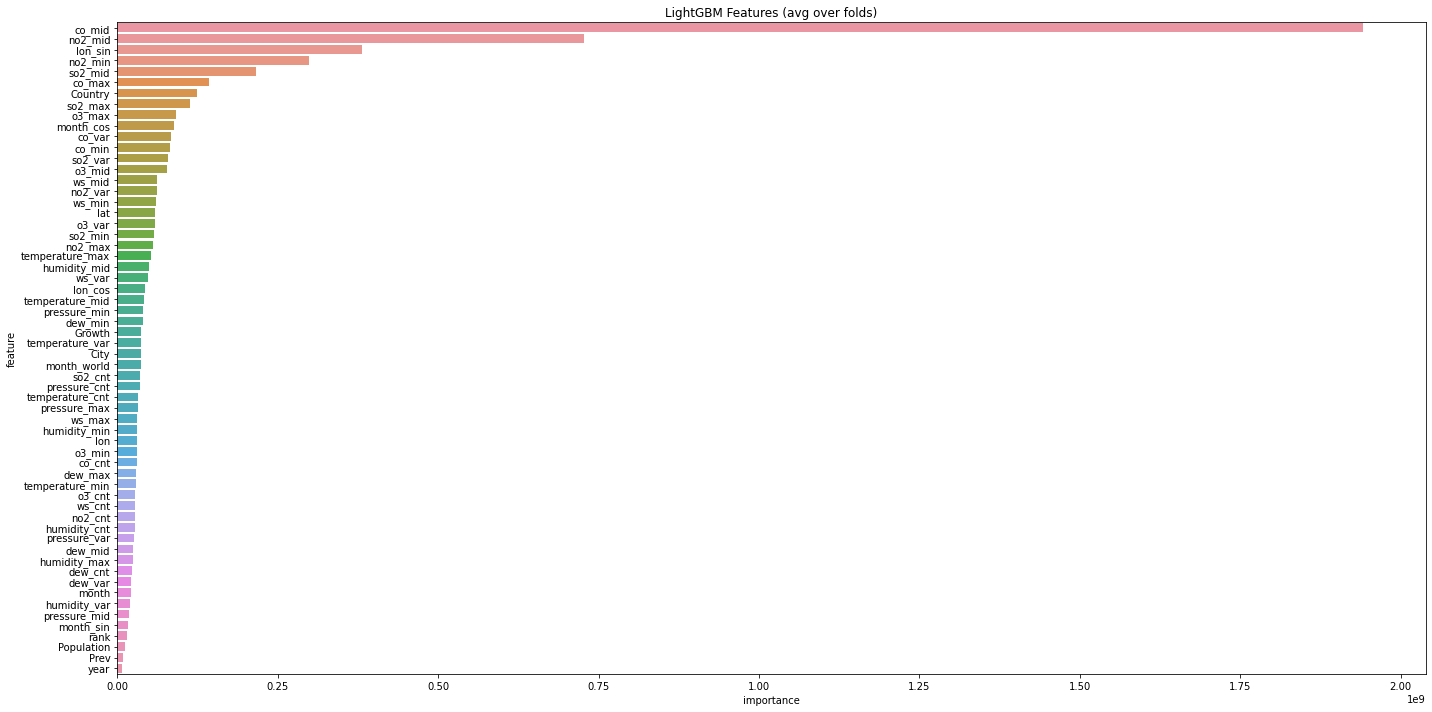

In [98]:
viz_feature_importances(feature_importance)

In [99]:
oof_score = np.sqrt(mean_squared_error(train_oof["pm25_mid"], train_oof["oof"]))
oof_score = format(oof_score, ".3f")
print(f"oof score: {oof_score}")

# 22.332
# 22.333 now

oof score: 22.159


In [100]:
train_oof[["id","pm25_mid", "kfold", "oof"]].to_csv(os.path.join(OOF_DIR, "oof.csv"), index= False)

# predict

In [101]:
sum_predict = None
for model in models:
    predict = model.predict(
        test_df_[use_cols],
    )
    if sum_predict is None:
        sum_predict = predict
    else:
        sum_predict += predict

mean_predict = sum_predict / len(models)

In [102]:
print(len(mean_predict))
print(sample_df.shape)
print(test_df.shape)

53509
(53509, 2)
(53509, 57)


In [103]:
sample_df.loc[:,"predict"] = mean_predict

In [104]:
sample_df.head()

,id,predict
0,195942,32.219262
1,195943,34.120460
2,195944,24.159254
3,195945,62.709874
4,195946,137.972062


In [105]:
sample_df.to_csv(os.path.join(SUB_DIR, "submission.csv"), index= False, header = False)

# submit

In [106]:
!pip install signate > /dev/null
!mkdir /root/.signate
!cp /content/drive/MyDrive/signate/signate.json /root/.signate/signate.json

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [107]:
submission_file = os.path.join(SUB_DIR, "submission.csv")

In [108]:
comment = f"cv:{oof_score}_" + NOTEBOOK_NAME
comment

'cv:22.159_FP009-008-tuning'

# Submit

In [109]:
!signate submit --competition-id=624 {submission_file} --note {comment}

You have successfully submitted your predictions.We will send you the submission result to your email address.


https://signate.jp/competitions/624/submissions